In [1]:
import rooms.dataset
import render_optimized as render
import torch
import torch.nn as nn
import metrics
import train
import os
import numpy as np
import evaluate
import trace1

import matplotlib.pyplot as plt

/home/gzanin/.local/lib/python3.11/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
torch.set_default_dtype(torch.float32)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
dataset_name = "espoo_S2"

D = rooms.dataset.dataLoader(dataset_name)

In [ ]:
#training parameters

n_fibonacci = 128 #128 
late_stage_model= "UniformResidual" #"UniformResidual"
toa_perturb = True #True
model_transmission = False #False

skip_train = False #False
continue_train = True #False ############

n_epochs = 500 #1000 
batch_size = 7 #4 #4 nel test ##############If dataset has different microphone types better if batch_size divides N_train and the number of microphones of different type!!!!!!
lr = 1e-2 #1e-2
pink_noise_supervision = True #True
pink_start_epoch = 250 #500
fs = 48000 #48000 

load_dir= 'precomputed/' + dataset_name
#save_dir= '~/espoo_s2_200amb+300om_epochs'
save_dir= '~/espoo_s2_200amb+300om_6mics'

skip_inference = False #False
skip_music = True #False
skip_eval = False #False
skip_binaural = True #False

valid = False #False #Evaluate on valid instead of test

In [5]:
R = render.Renderer(n_surfaces=len(D.all_surfaces), n_fibonacci=n_fibonacci,
                        late_stage_model=late_stage_model,
                        toa_perturb = toa_perturb, model_transmission=model_transmission).to(device)

In [6]:
# Use multiple GPUs if available
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    R = nn.DataParallel(R).module

In [7]:
# Omnidirectional case

loss_fcn = metrics.training_loss

gt_audio = torch.Tensor(D.RIRs[:, :R.RIR_length])

#rendering_method = render.Renderer.render_RIR


solo per training le prossime

In [8]:
def initialize(indices, source_xyz, listener_xyzs, surfaces, load_dir,
               ######################################################
                rendering_methods,
                mic_orientations,
                mic_0_gains,
                mic_180_loss,
                cardioid_exponents):
    Ls = []

    for idx in indices:
        L= render.get_listener(source_xyz=source_xyz, listener_xyz = listener_xyzs[idx], surfaces = surfaces, 
                               load_dir = load_dir, load_num = idx, speed_of_sound = D.speed_of_sound, 
                               max_order = D.max_order, parallel_surface_pairs = D.parallel_surface_pairs, 
                               max_axial_order = D.max_axial_order, 
                               ####################################################
                               rendering_method = rendering_methods[idx], mic_orientation = mic_orientations[idx], mic_0_gains = mic_0_gains[idx], mic_180_loss = mic_180_loss[idx], cardioid_exponents = cardioid_exponents[idx])
        Ls.append(L)
    return Ls

In [9]:
"""
Training
"""
if not skip_train:
    print("Training")

    #Initialize Listeners
    Ls = initialize(indices=D.train_indices,
                    listener_xyzs=D.xyzs,
                    source_xyz=D.speaker_xyz,
                    surfaces=D.all_surfaces,
                    load_dir=load_dir,
                    #######################################
                    rendering_methods = D.rendering_methods, #############should define the rendering method for every listener!!!!!!!!!!!!!!!!!!!!!!!!
                    mic_orientations = D.mic_orientations,#############and all this other stuff!!!!!!!!!!!
                    mic_0_gains= D.mic_0_gains, ############################it's needed for the microphone responses!!!!!!!!!!!!!!!!!!!!!!
                    mic_180_loss = D.mic_180_loss,
                    cardioid_exponents = D.cardioid_exponents)
    if continue_train:
        R.load_state_dict(torch.load(os.path.join(save_dir,"weights.pt"), map_location = device)['model_state_dict'])

    losses = train.train_loop(R=R, Ls=Ls, train_gt_audio=gt_audio[D.train_indices], D=D,
                        n_epochs = n_epochs, batch_size = batch_size, lr = lr, loss_fcn = loss_fcn,
                        save_dir=save_dir,
                        pink_noise_supervision = pink_noise_supervision,
                        pink_start_epoch=pink_start_epoch,
                        continue_train = continue_train, fs=fs)

else:
    R.load_state_dict(torch.load(os.path.join(save_dir,"weights.pt"))['model_state_dict'])
    R.train = False
    R.toa_perturb = False

Training
Listener Loading From: precomputed/espoo_S2
Listener Loading From: precomputed/espoo_S2
Listener Loading From: precomputed/espoo_S2
Listener Loading From: precomputed/espoo_S2
Listener Loading From: precomputed/espoo_S2
Listener Loading From: precomputed/espoo_S2


/tmp/ipykernel_68432/3893329438.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  R.load_state_dict(torch.load(os.path.join(save_dir,"weights.pt"), map_location = device)

FileNotFoundError: [Errno 2] No such file or directory: '~/espoo_s2_200amb+300om_epochs_6mics/weights.pt'

Inference and evaluation

In [ ]:
dataset_name = "espoo_S2"

D = rooms.dataset.dataLoader(dataset_name)

In [ ]:
print(D.test_indices)

In [ ]:
R = render.Renderer(n_surfaces=len(D.all_surfaces), n_fibonacci=n_fibonacci,
                        late_stage_model=late_stage_model,
                        toa_perturb = toa_perturb, model_transmission=model_transmission).to(device) 

In [ ]:
gt_audio = torch.Tensor(D.RIRs[:, :R.RIR_length])

In [ ]:
pt_file = torch.load(save_dir + '/weights.pt', map_location=device)
R.energy_vector = nn.Parameter(pt_file['model_state_dict']['energy_vector'])
R.source_response = nn.Parameter(pt_file['model_state_dict']['source_response'])
R.directivity_sphere = nn.Parameter(pt_file['model_state_dict']['directivity_sphere'])
R.decay = nn.Parameter(pt_file['model_state_dict']['decay'])
R.RIR_residual = nn.Parameter(pt_file['model_state_dict']['RIR_residual'])
R.spline_values = nn.Parameter(pt_file['model_state_dict']['spline_values'])

R.bp_ord_cut_freqs = nn.Parameter(pt_file['model_state_dict']['bp_ord_cut_freqs'])

/tmp/ipykernel_48181/4204995420.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pt_file = torch.load(save_dir + '/weights.pt', map_location=device)


In [ ]:
#Note - this function relies on precomputed reflection paths
#########above in the original code, I added the case where there are no precomputed paths
def inference(R, source_xyz, xyzs, load_dir, source_axis_1=None, source_axis_2=None):
    """
    Render monoaural RIRs at given precomputed reflection paths.

    Parameters
    ----------
    R: Renderer
        renderer to perform inference on
    source_xyz: np.array (3,)
        3D location of source in meters
    xyzs: np.array (N, 3)
        set of listener locations to render at
    load_dir: str
        directory to load precomputed listener paths
    source_axis_1: np.array (3,)
        first axis specifying virtual source rotation,
        default is None which is (1,0,0)
    source_axis_2: np.array (3,)
        second axis specifying virtual source rotation,
        default is None which is (0,1,0)    

    Returns
    -------
    predictions: np.array (N, T) of predicted RIRs    
    """

    predictions = np.zeros((xyzs.shape[0], R.RIR_length))

    with torch.no_grad():
        R.toa_perturb = False
        for idx in range(xyzs.shape[0]):
            print(idx, flush=True)
            
            if load_dir is None: 
                # Tracing from Scratch
                reflections, transmissions, delays, start_directions, end_directions = (
                    trace1.get_reflections_transmissions_and_delays(
                    source=source_xyz, dest=xyzs[idx], surfaces=D.all_surfaces, speed_of_sound=D.speed_of_sound,
                    max_order=D.max_order,parallel_surface_pairs=D.parallel_surface_pairs, max_axial_order=D.max_axial_order)
                )
                
            else:   
                reflections = np.load(os.path.join(load_dir, "reflections/"+str(idx)+".npy"), allow_pickle=True)
                transmissions = np.load(os.path.join(load_dir, "transmissions/"+str(idx)+".npy"), allow_pickle=True)
                delays = np.load(os.path.join(load_dir, "delays/"+str(idx)+".npy"),allow_pickle=True)
                start_directions = np.load(os.path.join(load_dir, "starts/"+str(idx)+".npy"))
                end_directions = np.load(os.path.join(load_dir, "ends/"+str(idx)+".npy"))

            L = render.ListenerLocation(
                source_xyz=source_xyz,
                listener_xyz=xyzs[idx],
                n_surfaces=R.n_surfaces,
                reflections=reflections,
                transmissions=transmissions,
                delays=delays,
                start_directions = start_directions,
                end_directions=end_directions)
            ########################################################
            #predict = R.render_RIR(L, source_axis_1=source_axis_1, source_axis_2=source_axis_2)
            ########################################################
            predict = R.render_RIR_omni(L, source_axis_1=source_axis_1, source_axis_2=source_axis_2)
            
            predictions[idx] = predict.detach().cpu().numpy()

    return predictions

In [ ]:
"""
Inference, rendering RIR
"""
R.train = False
R.toa_perturb = False
###############################################
R.mic_direction = torch.Tensor([0,1,0])
R.mic_0_gain = {0: 0, 50:1, 1000:1, 5000: 1, 10000: 1, 15000: 1, 20000: 1}
R.mic_180_loss = {0:0, 50:0, 1000: 0,  5000: 0, 10000: 0, 15000: 0, 20000: 0}
###############################################
pred_dir = os.path.join(save_dir, "predictions")
if not skip_inference:
    pred_rirs = inference(R=R, source_xyz=D.speaker_xyz, 
                          xyzs=D.xyzs[:(len(D.train_indices)+len(D.test_indices) + len(D.valid_indices))],
                            load_dir=load_dir,
                            source_axis_1= np.array([0.648, -0.762, 0]),####s3 SOURCE ROTATION AXIS
                            source_axis_2= np.array([0.762, 0.648, 0]))
    train.makedir_if_needed(pred_dir)
    np.save(os.path.join(pred_dir, "pred_rirs.npy"), pred_rirs)

    if not skip_music:
        pred_music = evaluate.render_music(pred_rirs, D.music_dls)    
        np.save(os.path.join(pred_dir,"pred_musics.npy"), pred_music)
else:
    pred_rirs = np.load(os.path.join(pred_dir, "pred_rirs.npy"))
    pred_music = np.load(os.path.join(pred_dir, "pred_musics.npy"))
    
    
"""
Evaluation of Monoaural Audio Using Metrics
"""
if not skip_eval:
    errors_dir = os.path.join(save_dir, "errors")
    train.makedir_if_needed(errors_dir)
    list_of_metrics = metrics.baseline_metrics

    if valid:
        eval_indices = D.valid_indices
    else:
        eval_indices = D.test_indices

    # Evaluating RIR Interp
    for eval_metric in list_of_metrics:

        metric_name = eval_metric.__name__
        errors = evaluate.compute_error(pred_rirs, gt_audio, metric=eval_metric, device="cpu") #original code#changed cuda to cpu!!!!!!!!
        #errors = evaluate.compute_error(pred_rirs[eval_indices], gt_audio[eval_indices], metric=eval_metric)
        
        np.save(os.path.join(errors_dir, "errors_" + metric_name +".npy"), errors)
        print(metric_name + " Metric:", flush=True)
        print(np.mean(errors[eval_indices]))
        #print(np.mean(errors))
        
    # Evaluating Music Interp
    if not skip_music:
        for eval_metric in list_of_metrics:

            metric_name = eval_metric.__name__

            # Computing Error
            errors_music = evaluate.eval_music(pred_music, D.music, eval_metric)
            #errors_music = evaluate.eval_music(pred_music[eval_indices], D.music[eval_indices], eval_metric)
            
            np.save(os.path.join(errors_dir, "errors_music_" + metric_name +".npy"), errors_music)
            print(metric_name + " Music Metric:", flush=True)
            print(np.mean(errors_music[eval_indices]))
            #print(np.mean(errors_music))

0
1
2
3
4
5
6
multiscale_log_l1 Metric:
0.959359264356743
env_loss Metric:
0.22819484981371949
rt60_error Metric:
177.62771006992884
rt60_diff Metric:
0.005035714046763522


/home/gzanin/Desktop/hearinganythinganywhere/evaluate.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  errors[i] = metric(torch.tensor(predicted_audios[i]).to(device), torch.tensor(gt_audios[i]).to(device))


Binaural Rendering

In [14]:
import binauralize

"""
Binaural Rendering
"""
if not skip_binaural:
    pred_binaural_RIRs = []
    for i in range(D.bin_xyzs.shape[0]):
        binaural_RIR_xyz = D.bin_xyzs[i]
        bin_rir = binauralize.render_binaural(R=R, source_xyz = D.speaker_xyz,
                                            source_axis_1=None, source_axis_2=None,
                                            listener_xyz=binaural_RIR_xyz,
                                            listener_forward=D.default_binaural_listener_forward, 
                                            listener_left=D.default_binaural_listener_left,
                                            surfaces=D.all_surfaces,
                                            speed_of_sound=D.speed_of_sound,
                                            parallel_surface_pairs=D.parallel_surface_pairs,
                                            max_order=D.max_order, max_axial_order=D.max_axial_order)

        pred_binaural_RIRs.append(bin_rir)

    pred_binaural_RIRs = np.array(pred_binaural_RIRs)
    np.save(os.path.join(pred_dir, "pred_bin_RIRs.npy"), pred_binaural_RIRs)

    if not skip_music:
        pred_L = pred_binaural_RIRs[:,0,:]
        pred_R = pred_binaural_RIRs[:,1,:]

        pred_L_music = evaluate.render_music(pred_L, D.music_dls[:pred_L.shape[0]])
        pred_R_music = evaluate.render_music(pred_R, D.music_dls[:pred_R.shape[0]])

        pred_bin_music = np.stack((pred_L_music, pred_R_music), axis=2)
        print(pred_bin_music.shape)
        np.save(os.path.join(pred_dir, "pred_bin_musics.npy"), pred_bin_music)

prova di ascolto

In [15]:
listener_1 = render.get_listener(source_xyz= np.array([5,3,1.5]), listener_xyz = np.array([5,7,1.5]), surfaces = D.all_surfaces, 
                               load_dir = load_dir, load_num = 0, speed_of_sound = D.speed_of_sound, 
                               max_order = D.max_order, parallel_surface_pairs = D.parallel_surface_pairs, 
                               max_axial_order = D.max_axial_order)

listener_2 = render.get_listener(source_xyz= np.array([9.9,9.9,2.9]), listener_xyz = np.array([5,3,1.5]), surfaces = D.all_surfaces, 
                               load_dir = load_dir, load_num = 1, speed_of_sound = D.speed_of_sound, 
                               max_order = D.max_order, parallel_surface_pairs = D.parallel_surface_pairs, 
                               max_axial_order = D.max_axial_order)

Listener Loading From: precomputed/espoo_S2
Listener Loading From: precomputed/espoo_S2


In [16]:
RIR_1 = R.render_RIR(listener_1)

In [17]:
RIR_2 = R.render_RIR(listener_2)

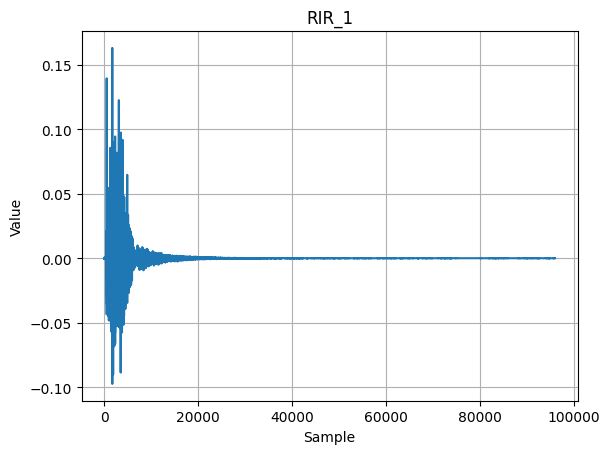

In [18]:
# RIR_1 plot
plt.plot(RIR_1.detach().cpu())
plt.title("RIR_1")
plt.xlabel("Sample")
plt.ylabel("Value")
plt.grid(True)
plt.show()

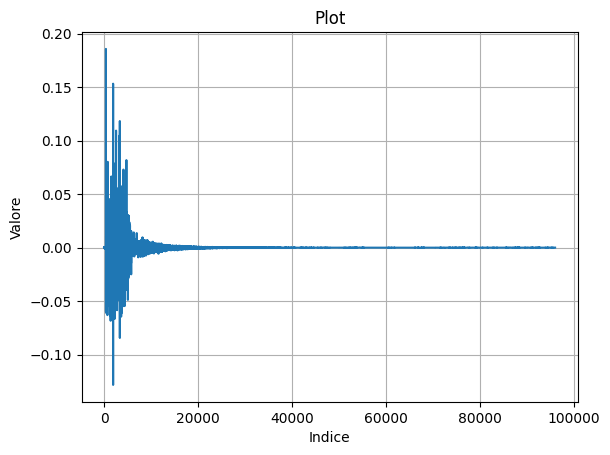

In [19]:
# RIR_2" plot
plt.plot(RIR_2.detach().cpu())
plt.title("Plot")
plt.xlabel("Indice")
plt.ylabel("Valore")
plt.grid(True)
plt.show()

In [20]:
predicted_music_1 = evaluate.render_music(np.array([RIR_1.detach().cpu()]), np.array([D.music_dls[0]]), device = device)
predicted_music_2 = evaluate.render_music(np.array([RIR_2.detach().cpu()]), np.array([D.music_dls[0]]), device = device)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
import sounddevice as sd

duration = predicted_music_1.shape[2]/fs  # Duration in seconds
t = np.linspace(0, duration, int(fs * duration), endpoint=False)


sd.play(predicted_music_1[0][0], samplerate=48000)
sd.wait()  


In [ ]:
duration = predicted_music_2.shape[2]/fs 
t = np.linspace(0, duration, int(fs * duration), endpoint=False)


sd.play(predicted_music_2[0][0], samplerate=48000)
sd.wait() 

In [ ]:
sd.play(D.music_dls[9][0], samplerate=48000)
sd.wait() 